In [18]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load cvs file
data = pd.read_csv('../../data/HateSpeechDatasetBalanced.csv')
data.rename(columns={'Label': 'labels', 'Content': 'text'}, inplace=True)

# Equilibrate the dataset
data = data.groupby('labels').head(10000)

# Shuffle the dataset 
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into training, validation, and test sets
df_train = data[:int(len(data) * 0.8)]
df_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
df_test = data[int(len(data) * 0.9):]

dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset = DatasetDict({
    'train': dataset_train.shuffle(seed=42),
    'val': dataset_val,
    'test': dataset_test
})

In [3]:
print(df_train)

                                                    text  labels
0      something must be done to halt this terrible w...       1
1      hey everyone i do not know really where to pos...       0
2      value your money value your dick don t buy tra...       0
3                         is my awakening still in print       0
4      gay families are not ok whatever should stop a...       1
...                                                  ...     ...
15995                      spark these bitches interests       0
15996    n gg need to go home something needs to be done       1
15997           i saw a white person in scarborough once       0
15998                     heck yeah and also she is cool       1
15999            try www amazon com or other booksellers       0

[16000 rows x 2 columns]


In [4]:
# Tokenization
MODEL_NAME = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if MODEL_NAME == "gpt2":
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

# Download the model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
if MODEL_NAME == "gpt2":
    model.config.pad_token_id = model.config.eos_token_id

/home/user/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Configure LoRA
lora_config = LoraConfig(
    r=8,  # Rank of the low-rank matrices
    lora_alpha=16,  # Scaling factor for the LoRA parameters
    lora_dropout=0.1,  # Dropout rate for LoRA
    target_modules=["query", "value"]  # Parts of the model to apply LoRA to
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

/home/user/.local/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [6]:
# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    tokenizer=tokenizer,
)

# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.633300,No log
2,0.569700,No log
3,0.571500,No log
4,0.534000,No log
5,0.540800,No log


TrainOutput(global_step=2500, training_loss=0.5934255363464356, metrics={'train_runtime': 1381.0039, 'train_samples_per_second': 57.929, 'train_steps_per_second': 1.81, 'total_flos': 2.112136200192e+16, 'train_loss': 0.5934255363464356, 'epoch': 5.0})

In [8]:
# Print training metrics
training_logs = trainer.state.log_history
train_loss = [log['loss'] for log in training_logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
train_accuracy = [log['train_accuracy'] for log in training_logs if 'train_accuracy' in log]
eval_accuracy = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]

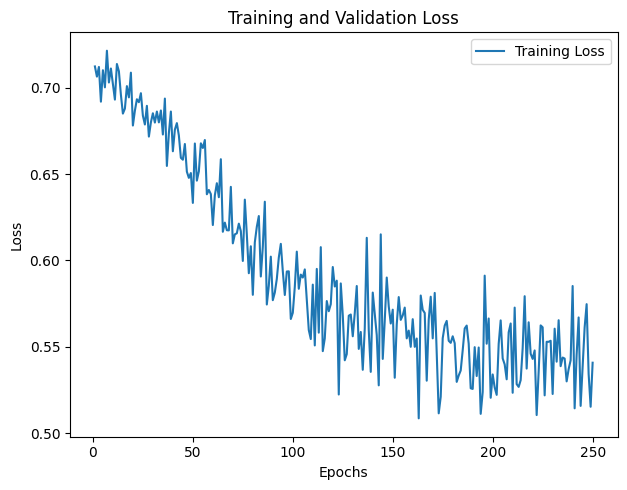

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
# plt.plot(epochs, eval_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_accuracy, label='Training Accuracy')
# plt.plot(epochs, eval_accuracy, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

In [20]:
# Model evaluation
predictions = trainer.predict(tokenized_datasets["test"])

Classification Report:
               precision    recall  f1-score   support

   Non-Toxic       0.74      0.78      0.76      1009
       Toxic       0.77      0.72      0.74       991

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



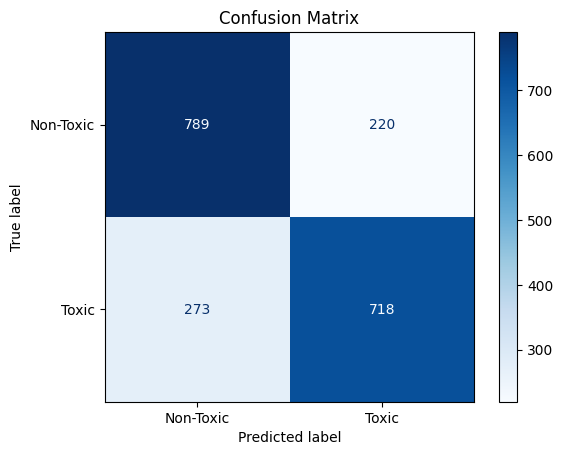

In [54]:
# Compute recall, precission, f1 score and accuracy
import numpy as np
# Extract predicted labels and true labels
y_true = tokenized_datasets["test"]["labels"]
y_pred = np.argmax(predictions.predictions[1], axis=1)


# Step 2: Generate classification report
report = classification_report(y_true, y_pred, target_names=["Non-Toxic", "Toxic"])
print("Classification Report:\n", report)

# Step 3: Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Toxic", "Toxic"])
disp.plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

In [55]:
# Save the model
model.save_pretrained("bert_model_lora")